# Compare the TNR Scores of DBNNs and Other Tests Using Set $\mathcal{C}$

## Set up the Environment

In [17]:
# Import everything that's needed to run the notebook
import os
import pickle
import dill
import pathlib
import datetime
import random
import time

from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import util
import robust
from ipynb.fs.defs.descriptor_based_neural_networks import DescriptorBuilder
from ipynb.fs.defs.construct_sbnn import SBNNPreprocessor
from sklearn.model_selection import learning_curve

plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)

In [18]:
# Define the path to the configuration dictionary
config_path = 'configuration.p'

# Load the configuration dictionary
with open(config_path, 'rb') as f:
    configuration = pickle.load(f)
    
# Get the paths to the relevant directories 
data_directory_path = configuration['data']['directory_path']
classifiers_directory_path = configuration['classifiers']['directory_path']

## Load the Storages of Results and Reports

In [19]:
dbnn_storage = {}

results_directory_path = configuration['results']['directory_path']
path = os.path.join(results_directory_path, 'dbnn_results.p')
with open(path, 'rb') as f:
    dbnn_storage['results'] = pickle.load(f)

reports_directory_path = configuration['reports']['directory_path']
path = os.path.join(reports_directory_path, 'dbnn')
path = os.path.join(path, 'dbnn_reports.p')
with open(path, 'rb') as f:
    dbnn_storage['reports'] = pickle.load(f)

## Load and Prepare Set $\mathcal{C}$

In [8]:
# Define the dictionary to store the actual datasets, indexed by their names
datasets = {}

# Load the datasets
for set_name in ['C-G1', 'C-G2', 'C-G3', 'C-G4']:
    set_path = configuration['data']['datasets'][set_name]['path']
    print('Loading {} from {}'.format(set_name, set_path))
    datasets[set_name] = util.load_from_file(set_path)
    print('Done.')

Loading C-G1 from data/C-G1.data
Done.
Loading C-G2 from data/C-G2.data
Done.
Loading C-G3 from data/C-G3.data
Done.
Loading C-G4 from data/C-G4.data
Done.


Separate the samples from the labels.

In [9]:
for set_name in datasets:
    labels = [sample.pop() for sample in datasets[set_name]]
    samples = datasets[set_name]
    
    datasets[set_name] = {'samples' : samples, 'labels' : labels}

## Load the Tests

In [37]:
# Make a dictionary to hold the tests
test_classifiers = {}

# Specify the classical tests
codes = ['SW', 'SF', 'LF', 'JB', 'DP', 'AD', 'CVM', 'FSSD']

# Load the classical tests
for test_code in codes:
    test, statistic = util.get_test(test_code)
    for alpha in [0.05]:
        test_classifiers[(test_code, alpha)] = util.TestClassifier(test, statistic, alpha)

# Although SBNN is not technically a test, consider it too.
with open(os.path.join('classifiers', 'sbnn.p'), 'rb') as f:
    sbnn = pickle.load(f)

test_classifiers[('SBNN', '')] = sbnn
codes += ['SBNN']

# Specify the robustified tests
robust_codes = ['MMRT1', 'MMRT2', 'TTRT1', 'TTRT2', 'RSW', 'RLM']

# Load the robustified tests
for test_code in robust_codes:
    test, statistic = robust.get_robust_test(test_code)
    for alpha in [0.05]:
        test_classifiers[(test_code, alpha)] = util.TestClassifier(test, statistic, alpha)

## Evaluate the Tests

Note that NPV is 1.0 for all the tests and networks since the set contains only non-normal (negative) samples, so we need to look at the TNR values only.

In [46]:
# Specify the sample sizes
n_range = range(10, 101, 10)

# Specify the metrics to calculate
metrics = ['TNR']

# Evaluate the tests on each group of samples in set C
for group in ['C-G1', 'C-G2', 'C-G3', 'C-G4']:
    print(group)
    
    samples = datasets[group]['samples']
    labels = datasets[group]['labels']
    
    # Create a dictionary to store the results
    all_test_results = {}
    
    for (test_code, alpha) in test_classifiers:
        # Evaluate the tests at the nominal alpha value of 0.05 only
        # (and SBNN)
        if alpha in ['', 0.05]:
            print('\t', test_code, end='')
            # Get the test
            test_clf = test_classifiers[(test_code, alpha)]
            
            # Evaluate it
            start = time.time()
            test_results_df = util.evaluate_pretty(samples, 
                                                   labels, 
                                                   test_clf, 
                                                   metrics=metrics, 
                                                   n_range=n_range, 
                                                   index='n')
            end = time.time()
            # Show how long its evaluation took and display the results
            print('\t', end - start)
            display(test_results_df.T)
            
            # Memorize the results
            all_test_results[test_code] = test_results_df
    
    # Put the results into the storage for persistence
    for test_code in all_test_results:
        test_results = all_test_results[test_code]
        memory = dbnn_storage['results']['comparison'].get(group, {})
        memory[test_code] = test_results
        dbnn_storage['results']['comparison'][group] = memory

C-G1
	 SW	 1.4186468124389648


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.251075,0.39696,0.488851,0.536646,0.592041,0.626837,0.662234,0.690631,0.721928,0.742326,0.570953


	 SF	 31.789493560791016


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.280172,0.437256,0.526447,0.584242,0.636236,0.668833,0.708729,0.731727,0.761524,0.778122,0.611329


	 LF	 37.817896366119385


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.240876,0.343566,0.425057,0.463254,0.511849,0.539946,0.567643,0.59654,0.621838,0.647835,0.49584


	 JB	 19.721808671951294


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.156084,0.359864,0.472953,0.537846,0.60324,0.640936,0.680232,0.706529,0.738526,0.759524,0.565573


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 101.73124885559082


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.279072,0.423658,0.507049,0.554445,0.605439,0.633837,0.664534,0.689131,0.717828,0.737326,0.581232


	 AD	 38.041953802108765


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.259374,0.409959,0.491351,0.531947,0.587141,0.614039,0.648935,0.676132,0.70293,0.724328,0.564614


	 CVM	 44.25270438194275


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.254975,0.384562,0.468853,0.513449,0.569443,0.59894,0.633537,0.663634,0.689331,0.714629,0.549135


	 FSSD	 566.8621368408203


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.132687,0.177482,0.210979,0.226177,0.243076,0.261174,0.276672,0.29617,0.30007,0.322468,0.244696


	 SBNN	 117.24990653991699


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.376762,0.525947,0.610539,0.661934,0.709829,0.723028,0.731127,0.732027,0.754425,0.784422,0.661004


	 MMRT1	 36.32234597206116


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.242776,0.40146,0.49995,0.557944,0.614839,0.652935,0.682032,0.713129,0.742426,0.768323,0.587581


	 MMRT2	 50.215301752090454


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.229977,0.40116,0.494251,0.551145,0.611639,0.649535,0.678332,0.707929,0.739426,0.762424,0.582582


	 TTRT1	 36.552770376205444


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.274173,0.188981,0.131287,0.338666,0.257074,0.432957,0.327567,0.478052,0.383562,0.554845,0.336716


	 TTRT2	 37.52134418487549


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.260374,0.390061,0.446255,0.511449,0.526047,0.577642,0.570043,0.615638,0.621338,0.667033,0.518588


	 RSW	 12.963388681411743


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.278472,0.451855,0.562644,0.625737,0.689531,0.722828,0.757424,0.775222,0.80052,0.817118,0.648135


	 RLM	 129.97999954223633


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.036696,0.087691,0.09579,0.117788,0.131087,0.128187,0.129887,0.138286,0.143486,0.144686,0.115358


aaaaaaaaaaaaaaaaaa SW
aaaaaaaaaaaaaaaaaa SF
aaaaaaaaaaaaaaaaaa LF
aaaaaaaaaaaaaaaaaa JB
aaaaaaaaaaaaaaaaaa DP
aaaaaaaaaaaaaaaaaa AD
aaaaaaaaaaaaaaaaaa CVM
aaaaaaaaaaaaaaaaaa FSSD
aaaaaaaaaaaaaaaaaa SBNN
aaaaaaaaaaaaaaaaaa MMRT1
aaaaaaaaaaaaaaaaaa MMRT2
aaaaaaaaaaaaaaaaaa TTRT1
aaaaaaaaaaaaaaaaaa TTRT2
aaaaaaaaaaaaaaaaaa RSW
aaaaaaaaaaaaaaaaaa RLM
C-G2
	 SW	 2.115544080734253


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.148685,0.310169,0.453755,0.587841,0.694931,0.762124,0.838416,0.880312,0.916408,0.942606,0.653525


	 SF	 45.665876150131226


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.156584,0.310469,0.441956,0.569943,0.678732,0.744926,0.821218,0.865013,0.905209,0.935206,0.642926


	 LF	 39.89034104347229


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.113289,0.19928,0.273373,0.361064,0.436456,0.506549,0.571843,0.630237,0.687731,0.733727,0.451355


	 JB	 21.219380378723145


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.049095,0.20148,0.326867,0.449055,0.570843,0.646335,0.735826,0.794821,0.847515,0.893811,0.551565


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 111.163254737854


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.156784,0.290771,0.40056,0.505249,0.615238,0.677932,0.760624,0.809719,0.860914,0.90171,0.59795


	 AD	 39.982436656951904


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.139786,0.29617,0.406159,0.516148,0.609539,0.669333,0.752725,0.810219,0.846415,0.884112,0.593061


	 CVM	 45.353609800338745


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.129287,0.244976,0.348665,0.460054,0.551245,0.618838,0.69803,0.758524,0.807319,0.847215,0.546415


	 FSSD	 555.5821640491486


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.080092,0.111389,0.131487,0.158384,0.179282,0.207079,0.231177,0.260974,0.285271,0.318468,0.19636


	 SBNN	 136.2315957546234


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.293071,0.437156,0.59774,0.663334,0.718928,0.758924,0.820118,0.852915,0.883012,0.916808,0.694201


	 MMRT1	 39.38676977157593


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.150585,0.294971,0.422058,0.536846,0.635536,0.70283,0.765323,0.814719,0.863514,0.905409,0.609179


	 MMRT2	 60.630383253097534


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.138486,0.291071,0.408559,0.523148,0.636936,0.70063,0.759724,0.811719,0.863714,0.90251,0.60365


	 TTRT1	 44.90979361534119


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.134887,0.136686,0.209479,0.229677,0.229477,0.265573,0.231077,0.282072,0.256074,0.355164,0.233017


	 TTRT2	 45.068519115448


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.153085,0.239676,0.389061,0.465453,0.575942,0.605739,0.691331,0.731327,0.79752,0.824318,0.547345


	 RSW	 16.886029481887817


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.111689,0.183382,0.241576,0.294071,0.344466,0.375362,0.407859,0.441656,0.470553,0.510349,0.338096


	 RLM	 117.6183807849884


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.015498,0.048895,0.012699,0.024998,0.007499,0.012899,0.0044,0.009099,0.0048,0.0038,0.014459


aaaaaaaaaaaaaaaaaa SW
aaaaaaaaaaaaaaaaaa SF
aaaaaaaaaaaaaaaaaa LF
aaaaaaaaaaaaaaaaaa JB
aaaaaaaaaaaaaaaaaa DP
aaaaaaaaaaaaaaaaaa AD
aaaaaaaaaaaaaaaaaa CVM
aaaaaaaaaaaaaaaaaa FSSD
aaaaaaaaaaaaaaaaaa SBNN
aaaaaaaaaaaaaaaaaa MMRT1
aaaaaaaaaaaaaaaaaa MMRT2
aaaaaaaaaaaaaaaaaa TTRT1
aaaaaaaaaaaaaaaaaa TTRT2
aaaaaaaaaaaaaaaaaa RSW
aaaaaaaaaaaaaaaaaa RLM
C-G3
	 SW	 1.7705795764923096


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.520048,0.743726,0.834417,0.881912,0.915008,0.930707,0.945505,0.957604,0.966103,0.972203,0.866723


	 SF	 35.88060259819031


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.512749,0.726927,0.819418,0.867713,0.90241,0.919408,0.933407,0.947705,0.954505,0.962304,0.854655


	 LF	 37.849491596221924


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.407359,0.618038,0.720828,0.780222,0.821718,0.848515,0.871013,0.888511,0.90201,0.912509,0.777072


	 JB	 18.48355770111084


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.242876,0.559444,0.70303,0.784022,0.843716,0.873613,0.89631,0.913109,0.924908,0.932007,0.767303


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 102.15087628364563


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.415458,0.639236,0.746225,0.810219,0.861914,0.885611,0.905909,0.924208,0.932507,0.941106,0.806239


	 AD	 33.0966796875


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.50405,0.723228,0.80492,0.855114,0.886011,0.90481,0.920008,0.933507,0.936906,0.945205,0.841376


	 CVM	 40.27180552482605


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.480652,0.686331,0.776922,0.829917,0.866613,0.884712,0.90301,0.921108,0.925107,0.933407,0.820778


	 FSSD	 583.8337314128876


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.208579,0.315868,0.379162,0.432657,0.480752,0.506249,0.532247,0.558544,0.575142,0.590841,0.458004


	 SBNN	 135.8644037246704


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.649035,0.774323,0.862914,0.892211,0.907209,0.916908,0.927207,0.937506,0.940006,0.944606,0.875192


	 MMRT1	 38.81515955924988


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.49855,0.69923,0.789021,0.839116,0.877312,0.893811,0.908209,0.924008,0.930007,0.939906,0.829917


	 MMRT2	 50.70609450340271


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.474653,0.69823,0.784122,0.836916,0.878112,0.893611,0.909409,0.925007,0.931307,0.940606,0.827197


	 TTRT1	 37.83560490608215


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.344466,0.343266,0.388561,0.513749,0.460854,0.606739,0.526147,0.677832,0.589041,0.794121,0.524478


	 TTRT2	 37.44183135032654


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.448455,0.629037,0.762824,0.806119,0.856914,0.868513,0.888111,0.90151,0.915108,0.919408,0.7996


	 RSW	 13.889033794403076


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.357164,0.532547,0.609739,0.660334,0.709029,0.730927,0.743826,0.763624,0.780722,0.794821,0.668273


	 RLM	 135.78919959068298


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.006399,0.082192,0.029897,0.064194,0.031697,0.056494,0.038496,0.047995,0.041796,0.055994,0.045515


aaaaaaaaaaaaaaaaaa SW
aaaaaaaaaaaaaaaaaa SF
aaaaaaaaaaaaaaaaaa LF
aaaaaaaaaaaaaaaaaa JB
aaaaaaaaaaaaaaaaaa DP
aaaaaaaaaaaaaaaaaa AD
aaaaaaaaaaaaaaaaaa CVM
aaaaaaaaaaaaaaaaaa FSSD
aaaaaaaaaaaaaaaaaa SBNN
aaaaaaaaaaaaaaaaaa MMRT1
aaaaaaaaaaaaaaaaaa MMRT2
aaaaaaaaaaaaaaaaaa TTRT1
aaaaaaaaaaaaaaaaaa TTRT2
aaaaaaaaaaaaaaaaaa RSW
aaaaaaaaaaaaaaaaaa RLM
C-G4
	 SW	 2.367818593978882


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.110389,0.255174,0.360264,0.430957,0.484952,0.531747,0.567143,0.588141,0.607439,0.633437,0.456964


	 SF	 45.59847974777222


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.076292,0.157484,0.255874,0.330967,0.380862,0.431557,0.474653,0.50325,0.529847,0.552545,0.369333


	 LF	 48.55520510673523


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.076092,0.126787,0.187581,0.242276,0.30327,0.337766,0.372263,0.40016,0.435056,0.449855,0.293111


	 JB	 24.43646550178528


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0035,0.0029,0.0008,0.0006,0.007899,0.085791,0.20358,0.279972,0.338866,0.39626,0.132017


	 DP

/home/milos/statisticka_klasifikacija/p39normal/lib/python3.9/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


	 105.2603988647461


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.043396,0.184382,0.341266,0.451855,0.523848,0.576742,0.624538,0.644936,0.670733,0.69633,0.475802


	 AD	 37.27980136871338


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.10319,0.243776,0.334467,0.39786,0.439656,0.479852,0.515448,0.535646,0.560944,0.579642,0.419048


	 CVM	 38.55841660499573


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.092291,0.185781,0.276572,0.341066,0.392161,0.431257,0.465253,0.489051,0.519548,0.535746,0.372873


	 FSSD	 633.7291905879974


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.0006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00006


	 SBNN	 129.42968702316284


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.162884,0.144186,0.183682,0.228477,0.245075,0.256174,0.261074,0.265973,0.269373,0.277272,0.229417


	 MMRT1	 38.06304097175598


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.075092,0.077392,0.10359,0.146185,0.224378,0.307669,0.349065,0.408259,0.465053,0.517748,0.267443


	 MMRT2	 51.66784381866455


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.091291,0.122988,0.154285,0.20488,0.289271,0.360264,0.385761,0.441656,0.49625,0.537846,0.308449


	 TTRT1	 35.182701110839844


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.019898,0.062594,0.029997,0.190081,0.10369,0.412159,0.285671,0.523448,0.512749,0.634837,0.277512


	 TTRT2	 36.910139322280884


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.026097,0.023798,0.021998,0.025897,0.024298,0.027797,0.024398,0.027197,0.031097,0.031297,0.026387


	 RSW	 14.700426816940308


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.020598,0.008299,0.0025,0.0022,0.0011,0.0017,0.0014,0.0012,0.0004,0.0005,0.00399


	 RLM	 144.75779223442078


n,10,20,30,40,50,60,70,80,90,100,overall
TNR,0.09849,0.10019,0.125387,0.131187,0.140886,0.132987,0.139586,0.140586,0.151085,0.141686,0.130207


aaaaaaaaaaaaaaaaaa SW
aaaaaaaaaaaaaaaaaa SF
aaaaaaaaaaaaaaaaaa LF
aaaaaaaaaaaaaaaaaa JB
aaaaaaaaaaaaaaaaaa DP
aaaaaaaaaaaaaaaaaa AD
aaaaaaaaaaaaaaaaaa CVM
aaaaaaaaaaaaaaaaaa FSSD
aaaaaaaaaaaaaaaaaa SBNN
aaaaaaaaaaaaaaaaaa MMRT1
aaaaaaaaaaaaaaaaaa MMRT2
aaaaaaaaaaaaaaaaaa TTRT1
aaaaaaaaaaaaaaaaaa TTRT2
aaaaaaaaaaaaaaaaaa RSW
aaaaaaaaaaaaaaaaaa RLM


## Create the Tables of Results

In [48]:
C_results = {}
for group in dbnn_storage['results']['comparison']:
    # Ignore the results on other sets
    print(group)
    if group[0] != 'C':
        continue
        
    
    # Merge all the results into the same table
    results = dbnn_storage['results']['comparison'][group]
    results_dict = {test_code: results[test_code]['TNR'] for test_code in results}
    results_df = pd.concat(results_dict, axis=1)
    results_df = results_df[sorted(results_df.columns)]
    
    # Add the results of DBNNs
    for name in ['DBNN', 'DBNN(opt)', 'DBNN(0.05)']:
        results_df[name] = dbnn_storage['results']['evaluation'][name][group]['TNR']
    # list(sorted(dbnns.keys()))
    results_df = results_df[[col for col in results_df.columns]]
    
    C_results[group] = results_df
    
    ds = results_df.T.sort_values(by='overall', ascending=False)
    display(ds)
    
    #print(util.get_latex_table(ds, caption=group, label=group, float_format='$%.2f$', index=True))
    

C-G1


n,10,20,30,40,50,60,70,80,90,100,overall
DBNN,0.956204,0.962104,0.955204,0.938806,0.910109,0.891511,0.880212,0.886211,0.891411,0.912809,0.918458
DBNN(opt),0.959704,0.961304,0.962704,0.960604,0.911609,0.886811,0.884612,0.893811,0.856414,0.885011,0.916258
DBNN(0.05),0.444756,0.627437,0.722828,0.783722,0.817018,0.845215,0.859414,0.879312,0.891411,0.900710,0.777182
SBNN,0.376762,0.525947,0.610539,0.661934,0.709829,0.723028,0.731127,0.732027,0.754425,0.784422,0.661004
RSW,0.278472,0.451855,0.562644,0.625737,0.689531,0.722828,0.757424,0.775222,0.800520,0.817118,0.648135
SF,0.280172,0.437256,0.526447,0.584242,0.636236,0.668833,0.708729,0.731727,0.761524,0.778122,0.611329
MMRT1,0.242776,0.401460,0.499950,0.557944,0.614839,0.652935,0.682032,0.713129,0.742426,0.768323,0.587581
MMRT2,0.229977,0.401160,0.494251,0.551145,0.611639,0.649535,0.678332,0.707929,0.739426,0.762424,0.582582
DP,0.279072,0.423658,0.507049,0.554445,0.605439,0.633837,0.664534,0.689131,0.717828,0.737326,0.581232
SW,0.251075,0.396960,0.488851,0.536646,0.592041,0.626837,0.662234,0.690631,0.721928,0.742326,0.570953


C-G2


n,10,20,30,40,50,60,70,80,90,100,overall
DBNN,0.994901,0.996300,0.982202,0.956004,0.927607,0.921108,0.927607,0.939306,0.948505,0.963104,0.955664
DBNN(opt),0.998700,0.993801,0.999300,0.990001,0.929107,0.917208,0.930907,0.944006,0.911609,0.938006,0.955264
DBNN(0.05),0.374063,0.565843,0.695530,0.774123,0.819918,0.870913,0.905509,0.929807,0.948505,0.952205,0.783642
SBNN,0.293071,0.437156,0.597740,0.663334,0.718928,0.758924,0.820118,0.852915,0.883012,0.916808,0.694201
SW,0.148685,0.310169,0.453755,0.587841,0.694931,0.762124,0.838416,0.880312,0.916408,0.942606,0.653525
SF,0.156584,0.310469,0.441956,0.569943,0.678732,0.744926,0.821218,0.865013,0.905209,0.935206,0.642926
MMRT1,0.150585,0.294971,0.422058,0.536846,0.635536,0.702830,0.765323,0.814719,0.863514,0.905409,0.609179
MMRT2,0.138486,0.291071,0.408559,0.523148,0.636936,0.700630,0.759724,0.811719,0.863714,0.902510,0.603650
DP,0.156784,0.290771,0.400560,0.505249,0.615238,0.677932,0.760624,0.809719,0.860914,0.901710,0.597950
AD,0.139786,0.296170,0.406159,0.516148,0.609539,0.669333,0.752725,0.810219,0.846415,0.884112,0.593061


C-G3


n,10,20,30,40,50,60,70,80,90,100,overall
DBNN,0.964404,0.965903,0.963904,0.953605,0.946505,0.940106,0.940806,0.947705,0.945505,0.944706,0.951315
DBNN(opt),0.966103,0.965303,0.968403,0.969403,0.946805,0.938806,0.942906,0.949405,0.928007,0.929707,0.950485
DBNN(0.05),0.664634,0.820918,0.864814,0.892611,0.909409,0.920308,0.930607,0.943706,0.945505,0.938106,0.883062
SBNN,0.649035,0.774323,0.862914,0.892211,0.907209,0.916908,0.927207,0.937506,0.940006,0.944606,0.875192
SW,0.520048,0.743726,0.834417,0.881912,0.915008,0.930707,0.945505,0.957604,0.966103,0.972203,0.866723
SF,0.512749,0.726927,0.819418,0.867713,0.902410,0.919408,0.933407,0.947705,0.954505,0.962304,0.854655
AD,0.504050,0.723228,0.804920,0.855114,0.886011,0.904810,0.920008,0.933507,0.936906,0.945205,0.841376
MMRT1,0.498550,0.699230,0.789021,0.839116,0.877312,0.893811,0.908209,0.924008,0.930007,0.939906,0.829917
MMRT2,0.474653,0.698230,0.784122,0.836916,0.878112,0.893611,0.909409,0.925007,0.931307,0.940606,0.827197
CVM,0.480652,0.686331,0.776922,0.829917,0.866613,0.884712,0.903010,0.921108,0.925107,0.933407,0.820778


C-G4


n,10,20,30,40,50,60,70,80,90,100,overall
DBNN(opt),1.000000,0.995500,0.998100,0.901710,0.451055,0.238276,0.159584,0.101890,0.014499,0.009699,0.487031
DP,0.043396,0.184382,0.341266,0.451855,0.523848,0.576742,0.624538,0.644936,0.670733,0.696330,0.475802
DBNN,1.000000,0.997500,0.922908,0.698330,0.442056,0.252575,0.148085,0.090591,0.049095,0.029197,0.463034
SW,0.110389,0.255174,0.360264,0.430957,0.484952,0.531747,0.567143,0.588141,0.607439,0.633437,0.456964
AD,0.103190,0.243776,0.334467,0.397860,0.439656,0.479852,0.515448,0.535646,0.560944,0.579642,0.419048
CVM,0.092291,0.185781,0.276572,0.341066,0.392161,0.431257,0.465253,0.489051,0.519548,0.535746,0.372873
SF,0.076292,0.157484,0.255874,0.330967,0.380862,0.431557,0.474653,0.503250,0.529847,0.552545,0.369333
MMRT2,0.091291,0.122988,0.154285,0.204880,0.289271,0.360264,0.385761,0.441656,0.496250,0.537846,0.308449
LF,0.076092,0.126787,0.187581,0.242276,0.303270,0.337766,0.372263,0.400160,0.435056,0.449855,0.293111
TTRT1,0.019898,0.062594,0.029997,0.190081,0.103690,0.412159,0.285671,0.523448,0.512749,0.634837,0.277512


## Plot the Figures and Create the $\LaTeX$ Tables

For simplicity, show only the results of the DBNNs and its best five competitors in each group.

In [ ]:
for group in C_results:
    C_results[group].rename(columns={'SBNN(0.05)' : 'SBNN'}, inplace=True)

In [49]:
competitors = [name[0] for name in test_classifiers.keys()]

dbnn_cols = ['DBNN', 'DBNN(opt)', 'DBNN(0.05)']

selected_results = {}

for group in C_results:
    print(group)
    df_competition = C_results[group][competitors].T.sort_values(by='overall', ascending=False).head(5)
    df_dbnn = C_results[group][dbnn_cols].T
    selected_results[group] = df_dbnn.append(df_competition)

C-G1
C-G2
C-G3
C-G4


\begin{table}
\centering
\caption{C}
\label{c}
\begin{tabular}{lrrrrrrrrrrr}
\toprule
n &      10 &      20 &      30 &      40 &      50 &      60 &      70 &      80 &      90 &     100 &  overall \\
\midrule
AD         & $0.259$ & $0.410$ & $0.491$ & $0.532$ & $0.587$ & $0.614$ & $0.649$ & $0.676$ & $0.703$ & $0.724$ &  $0.565$ \\
CVM        & $0.255$ & $0.385$ & $0.469$ & $0.513$ & $0.569$ & $0.599$ & $0.634$ & $0.664$ & $0.689$ & $0.715$ &  $0.549$ \\
DP         & $0.279$ & $0.424$ & $0.507$ & $0.554$ & $0.605$ & $0.634$ & $0.665$ & $0.689$ & $0.718$ & $0.737$ &  $0.581$ \\
FSSD       & $0.133$ & $0.177$ & $0.211$ & $0.226$ & $0.243$ & $0.261$ & $0.277$ & $0.296$ & $0.300$ & $0.322$ &  $0.245$ \\
JB         & $0.156$ & $0.360$ & $0.473$ & $0.538$ & $0.603$ & $0.641$ & $0.680$ & $0.707$ & $0.739$ & $0.760$ &  $0.566$ \\
LF         & $0.241$ & $0.344$ & $0.425$ & $0.463$ & $0.512$ & $0.540$ & $0.568$ & $0.597$ & $0.622$ & $0.648$ &  $0.496$ \\
MMRT1      & $0.243$ & $0.401$ & $0.500

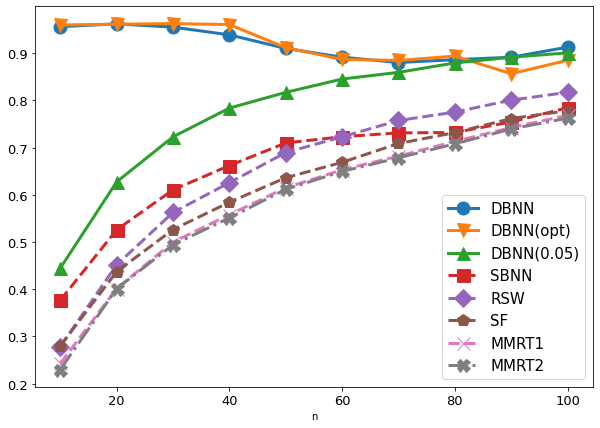

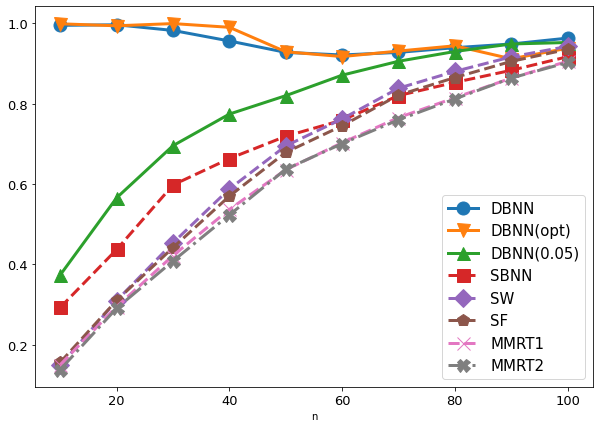

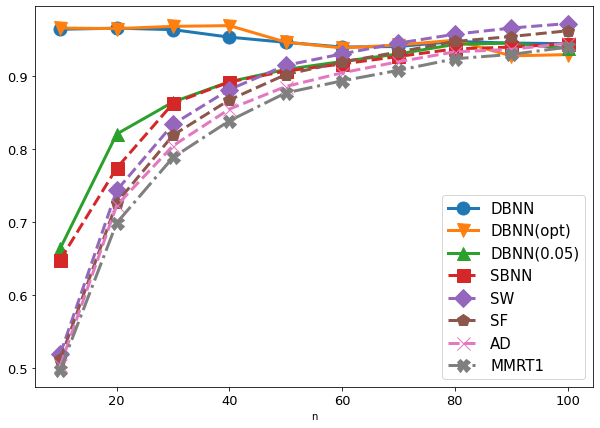

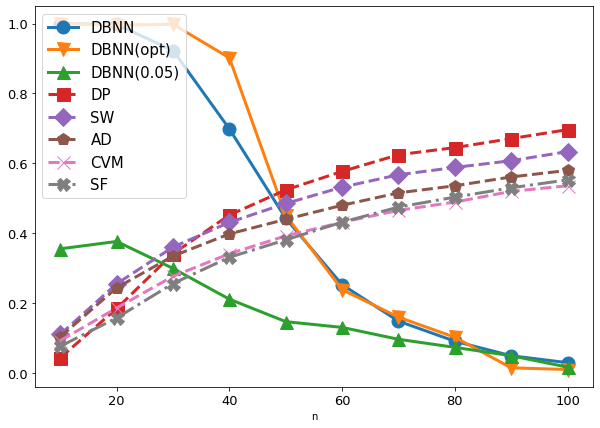

In [50]:
figures = {'reports' : {'comparison' : {}}}
for group in selected_results:
    df = selected_results[group].T
    fig = df[df.index != 'overall'].plot(kind='line', style=['o-', 'v-', '^-', 's--', 'D--', 'p--', 'x--', 'X-.'],
                                         #color=['navy', 'darkred', 'red', 'orangered', 'orange'],
                                         linewidth=3,
                                         markersize=13,
                                         figsize=(10,7), use_index=True)
    plt.legend(fontsize=15)
    latex = util.get_latex_table(C_results[group].T, index=True, caption='C', label='c')
    dbnn_storage['reports']['comparison'][group] = {'fig' : fig, 'latex': latex}
    figures['reports']['comparison'][group] = {'fig' : fig}
    print(latex)

## Save

In [51]:
results_directory_path = configuration['results']['directory_path']
path = os.path.join(results_directory_path, 'dbnn_results.p')
with open(path, 'wb') as f:
    pickle.dump(dbnn_storage['results'], f)

reports_directory_path = configuration['reports']['directory_path']
path = os.path.join(reports_directory_path, 'dbnn')
pathlib.Path(*path.split(os.sep)).mkdir(parents=True, exist_ok=True)

reports_directory_path = path
path = os.path.join(reports_directory_path, 'dbnn_reports.p')
with open(path, 'wb') as f:
    pickle.dump(dbnn_storage['reports'], f)

Save the figures.

In [53]:
util.traverse_and_save(figures, reports_directory_path)

Saving reports/dbnn/reports/comparison/C-G1/C-G1_fig.pdf
Saving reports/dbnn/reports/comparison/C-G1/C-G1_fig.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving reports/dbnn/reports/comparison/C-G2/C-G2_fig.pdf
Saving reports/dbnn/reports/comparison/C-G2/C-G2_fig.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving reports/dbnn/reports/comparison/C-G3/C-G3_fig.pdf
Saving reports/dbnn/reports/comparison/C-G3/C-G3_fig.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saving reports/dbnn/reports/comparison/C-G4/C-G4_fig.pdf
Saving reports/dbnn/reports/comparison/C-G4/C-G4_fig.eps


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
